In [1]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('EURUSD_15m.csv')
data.tail()

timestamp      open      high       low     close  \
15369  2022-06-30 16:45:00+01:00  1.046682  1.048438  1.046572  1.047120   
15370  2022-06-30 17:00:00+01:00  1.047120  1.047340  1.046463  1.046792   
15371  2022-06-30 17:15:00+01:00  1.046682  1.047779  1.046682  1.047669   
15372  2022-06-30 17:30:00+01:00  1.047889  1.048218  1.047230  1.047449   
15373  2022-06-30 17:45:00+01:00  1.047779  1.048878  1.047779  1.048438   

       adj close  volumn  
15369   1.047120       0  
15370   1.046792       0  
15371   1.047669       0  
15372   1.047449       0  
15373   1.048438       0

In [3]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df

timestamp      open      high       low     close  adj close  \
0     2021-11-04 17:00:00  1.154734  1.155135  1.154734  1.155135   1.155135   
1     2021-11-04 17:15:00  1.155135  1.155535  1.155001  1.155135   1.155135   
2     2021-11-04 17:30:00  1.155001  1.155535  1.155001  1.155135   1.155135   
3     2021-11-04 17:45:00  1.155001  1.155535  1.155001  1.155001   1.155001   
4     2021-11-04 18:00:00  1.155135  1.155535  1.155135  1.155535   1.155535   
...                   ...       ...       ...       ...       ...        ...   
15369 2022-06-30 15:45:00  1.046682  1.048438  1.046572  1.047120   1.047120   
15370 2022-06-30 16:00:00  1.047120  1.047340  1.046463  1.046792   1.046792   
15371 2022-06-30 16:15:00  1.046682  1.047779  1.046682  1.047669   1.047669   
15372 2022-06-30 16:30:00  1.047889  1.048218  1.047230  1.047449   1.047449   
15373 2022-06-30 16:45:00  1.047779  1.048878  1.047779  1.048438   1.048438   

       volumn  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
15369       0  
15370       0  
15371       0  
15372       0  
15373       0  

[15374 rows x 7 columns]

In [111]:
class RSI_and_EMA:
    def __init__(self, params):
        
        self.current_action = 'close'
        self.atr = params['atr']
        self.ema = params['ema']
        self.rsi = params['rsi']
        
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        
        self.df = params['df']
        self.unknow_result = []
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
        self.pip = params['pip']
        self.pip_value = params['pip_value']
        self.target_tp = params['target_tp']
        
        self.total_tp = 0
        self.total_sl = 0
        self.total_order = 0
        
    def get_df(self):
        return self.df
    
    def calLotSize(self, entry, exit):
        return abs(round(self.target_tp / (((entry - exit) / self.pip ) * self.pip_value ) , 2))
        
    def create_orders(self):
        rsi_ema = ta.Strategy(
            name = 'RSI 14 Days for opposite trade',
            description = 'RSI for alert',
            ta = [
                {'kind': 'ema', 'length': self.ema},
                {'kind': 'rsi', 'length': self.rsi},
                {'kind': 'atr', 'length': self.atr}
            ]
        )
        self.df.ta.strategy(rsi_ema)
        
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['action'] = None
        self.df['entries'] = False
        self.df['exits'] = False
        
        self.df['short_entries'] = False
        self.df['short_exits'] = False
        self.df['price_action'] = self.df['open']
        self.df['lot_size'] = np.nan
        
        for index, row in self.df.iterrows():
            if self.current_action == 'close':

                if row['EMA_'+str(self.ema)] < row['low'] and row['RSI_'+str(self.rsi)] > self.overbought:
                    self.total_order = self.total_order + 1
                    self.current_action = 'buy'
                    self.order['action'] = 'buy'
                    
                    self.order['open time'] = row['timestamp']
                    self.order['open'] = row['open']
                    self.order['S/L'] = row['low'] - row['ATRr_'+str(self.atr)]
                    self.order['T/P'] = row['open'] + (self.rr * abs(row['open'] - self.order['S/L']))

                    self.df.at[index, 'action'] = 'buy'
                    self.df.at[index, 'entries'] = True
                    self.df.at[index, 'price_action'] = row['open']
                    self.df.at[index, 'lot_size'] = self.calLotSize(self.order['open'], self.order['T/P'])

                elif row['EMA_'+str(self.ema)] > row['high'] and row['RSI_'+str(self.rsi)] < self.oversold:
                    self.total_order = self.total_order + 1
                    self.current_action = 'sell'
                    self.order['action'] = 'sell'
                    
                    self.order['open time'] = row['timestamp']
                    self.order['open'] = row['open']
                    self.order['S/L'] = row['high'] + row['ATRr_'+str(self.atr)]
                    self.order['T/P'] = row['open'] - (self.rr * abs(row['open'] - self.order['S/L']))

                    self.df.at[index, 'action'] = 'sell'
                    self.df.at[index, 'short_entries'] = True
                    self.df.at[index , 'price_action'] = row['open']
                    self.df.at[index, 'lot_size'] = self.calLotSize(self.order['open'], self.order['T/P'])

            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.total_sl = self.total_sl + 1
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    self.current_action = 'close'

                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'S/L'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    self.df.at[index, 'lot_size'] = 0
                    
                    self.order = {}
                    
                elif row['high'] >= self.order['T/P']:
                    self.total_tp = self.total_tp + 1
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    self.current_action = 'close'

                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'T/P'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    self.df.at[index, 'lot_size'] = 0
                    
                    self.order = {}

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    self.total_sl = self.total_sl + 1
                    
                if row['high'] >= self.order['S/L']:
                    self.total_sl = self.total_sl + 1
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    self.current_action = 'close'

                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'S/L'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    self.df.at[index, 'lot_size'] = 0
                    
                    self.order = {}
                    
                elif row['low'] <= self.order['T/P']:
                    self.total_tp = self.total_tp + 1
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    self.current_action = 'close'

                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'T/P'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    self.df.at[index, 'lot_size'] = 0
                    
                    self.order = {}
  
        try:
            win_rate = round(self.total_tp * 100 / self.total_order, 2)
            loss_rate = round(self.total_sl * 100 / self.total_order, 2)
            gain = (self.total_tp * self.rr) - self.total_sl

            result_info = f"total orders: {self.total_order}, rsi: {self.rsi}, overbought: {self.overbought}, oversold: {self.oversold}, ema: {self.ema}, atr: {self.atr}, gain: {gain}"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': self.total_order, 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
            return {'win_rate': 0, 'info': 'No orders to action'}

In [112]:
pair_test = RSI_and_EMA({
    'atr': 17,
    'rsi': 10,
    'ema': 200,
    'overbought': 73,
    'oversold': 27,
    'pip': 0.0001,
    'pip_value': 10,
    'rr': 1.5,
    'target_tp': 10,
    'df': df.copy()
})
result_test = pair_test.create_orders()
result_test

{'win_rate': 65.03,
 'info': 'total orders: 449, rsi: 10, overbought: 73, oversold: 27, ema: 200, atr: 17, gain: 282.0',
 'total_order': 449,
 'rr': 1.5,
 'gain': 282.0,
 'unknow': []}

In [79]:
pair_df = pair_test.get_df().copy()
# pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'], unit='ms')
pair_df = pair_df.set_index('timestamp')
pair_df[pair_df['lot_size'] > 0]

open      high       low     close  adj close  \
timestamp                                                                
2021-11-09 05:15:00  1.160362  1.160766  1.160227  1.160497   1.160497   
2021-11-10 07:30:00  1.157140  1.157274  1.156738  1.156872   1.156872   
2021-11-10 11:45:00  1.155268  1.155668  1.154868  1.155268   1.155268   
2021-11-10 15:15:00  1.154868  1.155268  1.153270  1.153270   1.153270   
2021-11-10 15:45:00  1.152074  1.152339  1.151676  1.152206   1.152206   
...                       ...       ...       ...       ...        ...   
2022-06-29 18:45:00  1.044714  1.044932  1.044386  1.044386   1.044386   
2022-06-30 10:45:00  1.041884  1.042101  1.040475  1.040583   1.040583   
2022-06-30 11:15:00  1.040799  1.040908  1.039717  1.039717   1.039717   
2022-06-30 11:45:00  1.039393  1.039717  1.038961  1.039717   1.039717   
2022-06-30 16:45:00  1.047779  1.048878  1.047779  1.048438   1.048438   

                     volumn   EMA_200     RSI_10   ATRr_17 action  entries  \
timestamp                                                                    
2021-11-09 05:15:00       0  1.156941  73.401401  0.000507    buy     True   
2021-11-10 07:30:00       0  1.158316  22.476142  0.000566   sell    False   
2021-11-10 11:45:00       0  1.158136  25.212227  0.000742   sell    False   
2021-11-10 15:15:00       0  1.157819  25.011589  0.001036   sell    False   
2021-11-10 15:45:00       0  1.157705  23.423832  0.001031   sell    False   
...                     ...       ...        ...       ...    ...      ...   
2022-06-29 18:45:00       0  1.052639  25.416686  0.000803   sell    False   
2022-06-30 10:45:00       0  1.048839  23.091938  0.000894   sell    False   
2022-06-30 11:15:00       0  1.048667  19.570700  0.000904   sell    False   
2022-06-30 11:45:00       0  1.048484  25.605239  0.000905   sell    False   
2022-06-30 16:45:00       0  1.047658  76.628102  0.001264    buy     True   

                     exits  short_entries  short_exits  price_action  \
timestamp                                                              
2021-11-09 05:15:00  False          False        False      1.160362   
2021-11-10 07:30:00  False           True        False      1.157140   
2021-11-10 11:45:00  False           True        False      1.155268   
2021-11-10 15:15:00  False           True        False      1.154868   
2021-11-10 15:45:00  False           True        False      1.152074   
...                    ...            ...          ...           ...   
2022-06-29 18:45:00  False           True        False      1.044714   
2022-06-30 10:45:00  False           True        False      1.041884   
2022-06-30 11:15:00  False           True        False      1.040799   
2022-06-30 11:45:00  False           True        False      1.039393   
2022-06-30 16:45:00  False          False        False      1.047779   

                     lot_size  T/P  S/L  
timestamp                                
2021-11-09 05:15:00      0.10  NaN  NaN  
2021-11-10 07:30:00      0.10  NaN  NaN  
2021-11-10 11:45:00      0.06  NaN  NaN  
2021-11-10 15:15:00      0.05  NaN  NaN  
2021-11-10 15:45:00      0.05  NaN  NaN  
...                       ...  ...  ...  
2022-06-29 18:45:00      0.07  NaN  NaN  
2022-06-30 10:45:00      0.06  NaN  NaN  
2022-06-30 11:15:00      0.07  NaN  NaN  
2022-06-30 11:45:00      0.05  NaN  NaN  
2022-06-30 16:45:00      0.05  NaN  NaN  

[358 rows x 18 columns]

In [80]:
pair_df.price_action

timestamp
2021-11-04 17:00:00    1.154734
2021-11-04 17:15:00    1.155135
2021-11-04 17:30:00    1.155001
2021-11-04 17:45:00    1.155001
2021-11-04 18:00:00    1.155135
                         ...   
2022-06-30 15:45:00    1.046682
2022-06-30 16:00:00    1.047120
2022-06-30 16:15:00    1.046682
2022-06-30 16:30:00    1.047889
2022-06-30 16:45:00    1.047779
Name: price_action, Length: 15374, dtype: float64

In [108]:
port = vbt.Portfolio.from_signals(pair_df.price_action,
                                  entries=pair_df.entries.astype('bool'),
                                  exits=pair_df.exits.astype('bool'),
                                  short_entries=pair_df.short_entries.astype('bool'),
                                  short_exits=pair_df.short_exits.astype('bool'),
                                  size=pair_df.lot_size, 
                                  freq="15m",
                                  init_cash=100,
                                  fees=0.0005, 
                                  slippage=0.001
                                 )

In [109]:
port.plot().show()

<AxesSubplot:xlabel='timestamp'>

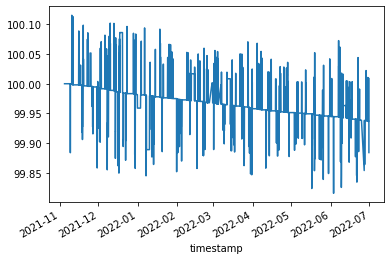

In [110]:
port.cash().plot()

In [107]:
port.stats()

Start                               2021-11-04 17:00:00
End                                 2022-06-30 16:45:00
Period                                160 days 03:30:00
Start Value                                       100.0
End Value                                     99.954284
Total Return [%]                              -0.045716
Benchmark Return [%]                          -9.262359
Max Gross Exposure [%]                         0.136131
Total Fees Paid                                0.007641
Max Drawdown [%]                               0.045716
Max Drawdown Duration                 157 days 20:30:00
Total Trades                                        358
Total Closed Trades                                 357
Total Open Trades                                     1
Open Trade PnL                                 -0.00006
Win Rate [%]                                   15.12605
Best Trade [%]                                 0.243775
Worst Trade [%]                               -0

In [99]:
port.orders.records_readable

Order Id  Column           Timestamp  Size     Price      Fees  Side
0           0       0 2021-11-09 05:15:00  0.10  1.161522  0.000116   Buy
1           1       0 2021-11-09 06:00:00  0.10  1.160279  0.000116  Sell
2           2       0 2021-11-10 07:30:00  0.10  1.155982  0.000116  Sell
3           3       0 2021-11-10 09:30:00  0.10  1.159504  0.000116   Buy
4           4       0 2021-11-10 11:45:00  0.06  1.154113  0.000069  Sell
..        ...     ...                 ...   ...       ...       ...   ...
710       710       0 2022-06-30 11:15:00  0.07  1.039759  0.000073  Sell
711       711       0 2022-06-30 11:30:00  0.07  1.039676  0.000073   Buy
712       712       0 2022-06-30 11:45:00  0.05  1.038354  0.000052  Sell
713       713       0 2022-06-30 12:15:00  0.05  1.041840  0.000052   Buy
714       714       0 2022-06-30 16:45:00  0.05  1.048827  0.000052   Buy

[715 rows x 7 columns]

In [86]:
port.trades.records_readable

Exit Trade Id  Column  Size     Entry Timestamp  Avg Entry Price  \
0                0       0  0.10 2021-11-09 05:15:00         1.161522   
1                1       0  0.10 2021-11-10 07:30:00         1.155982   
2                2       0  0.06 2021-11-10 11:45:00         1.154113   
3                3       0  0.05 2021-11-10 15:15:00         1.153713   
4                4       0  0.05 2021-11-10 15:45:00         1.150922   
..             ...     ...   ...                 ...              ...   
353            353       0  0.07 2022-06-29 18:45:00         1.043669   
354            354       0  0.06 2022-06-30 10:45:00         1.040842   
355            355       0  0.07 2022-06-30 11:15:00         1.039759   
356            356       0  0.05 2022-06-30 11:45:00         1.038354   
357            357       0  0.05 2022-06-30 16:45:00         1.048827   

     Entry Fees      Exit Timestamp  Avg Exit Price  Exit Fees       PnL  \
0           0.0 2021-11-09 06:00:00        1.160279        0.0 -0.000124   
1           0.0 2021-11-10 09:30:00        1.159504        0.0 -0.000352   
2           0.0 2021-11-10 13:15:00        1.157627        0.0 -0.000211   
3           0.0 2021-11-10 15:30:00        1.153093        0.0  0.000031   
4           0.0 2021-11-10 16:00:00        1.154689        0.0 -0.000188   
..          ...                 ...             ...        ...       ...   
353         0.0 2022-06-30 02:15:00        1.046852        0.0 -0.000223   
354         0.0 2022-06-30 11:00:00        1.041082        0.0 -0.000014   
355         0.0 2022-06-30 11:30:00        1.039676        0.0  0.000006   
356         0.0 2022-06-30 12:15:00        1.041840        0.0 -0.000174   
357         0.0 2022-06-30 16:45:00        1.047779        0.0 -0.000052   

       Return Direction  Status  Position Id  
0   -0.001071      Long  Closed            0  
1   -0.003047     Short  Closed            1  
2   -0.003045     Short  Closed            2  
3    0.000537     Short  Closed            3  
4   -0.003273     Short  Closed            4  
..        ...       ...     ...          ...  
353 -0.003050     Short  Closed          353  
354 -0.000230     Short  Closed          354  
355  0.000080     Short  Closed          355  
356 -0.003358     Short  Closed          356  
357 -0.000999      Long    Open          357  

[358 rows x 14 columns]